<a href="https://colab.research.google.com/github/Pugianf/Big_Data_and_Public_Sector_I/blob/main/Aula_6_2021_10_26_SeriesTemporais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise da População Ocupada no Brasil usando Séries Temporais

Dados: [PNADC/Sidra](https://sidra.ibge.gov.br/tabela/6320)

----

## Leitura dos Dados

In [ ]:
## Importando o que for necessário
import pandas as pd
import numpy as np
from scipy import stats
from zipfile import ZipFile
import statsmodels.api as sm
import statsmodels.stats.api as sms
from IPython.display import clear_output # limpa o output de uma célula
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
## Montando o Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Lendo os dados (trimestre iniciado em janeiro de 2012 ao inicio em maio de 2021)
sCaminho = "/content/drive/Othercomputers/Meu modelo MacBook Air/Documents/IPEA/Curso IDP/Dados/"
sArquivo = "populacao_ocupada.xlsx"

## Lendo o DataFrane
df = pd.read_excel(f"{sCaminho}{sArquivo}")

# Vendo o tamanho da base
print(f"Linhas: {df.shape[0]}; Colunas: {df.shape[1]}")

Linhas: 113; Colunas: 4


In [ ]:
## Convertendo a coluna de data pra datetime
df['data'] = pd.to_datetime(df['data'])

In [ ]:
## Vendo o DataFrame
df.head(20)

,data,ocupados,populacao,ocupados_populacao
0,2012-03-01,87632,197074,0.444665
1,2012-04-01,88407,197217,0.448273
2,2012-05-01,88863,197359,0.450261
3,2012-06-01,89129,197502,0.451282
4,2012-07-01,89181,197645,0.451218
5,2012-08-01,89428,197788,0.452141
6,2012-09-01,89639,197931,0.452880
7,2012-10-01,89723,198074,0.452977
8,2012-11-01,89867,198217,0.453377
9,2012-12-01,89857,198360,0.453000


## Análise Descritiva da Série

[Text(0, 0.5, 'Ocupados'),
 Text(0.5, 0, 'Mês e Ano'),
 Text(0.5, 1.0, 'População Ocupada por Trimestre Móvel (milhares)')]

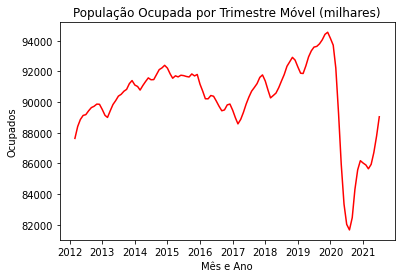

In [ ]:
## Grafando o comportamento da série
plt.plot(df.data, df.ocupados, color="red")
plt.gca().set(title="População Ocupada por Trimestre Móvel (milhares)", xlabel="Mês e Ano", ylabel="Ocupados")

In [ ]:
## Criando colunas de ano e mês
df['ano'] = [d.year for d in df.data]
df['mes'] = [d.strftime('%b') for d in df.data]

In [ ]:
## Vendo o comportamento mensal a partir de 2015
df2015 = df.query("data.dt.year >= 2015")

Text(0.5, 1.0, 'População Ocupada por Mês')

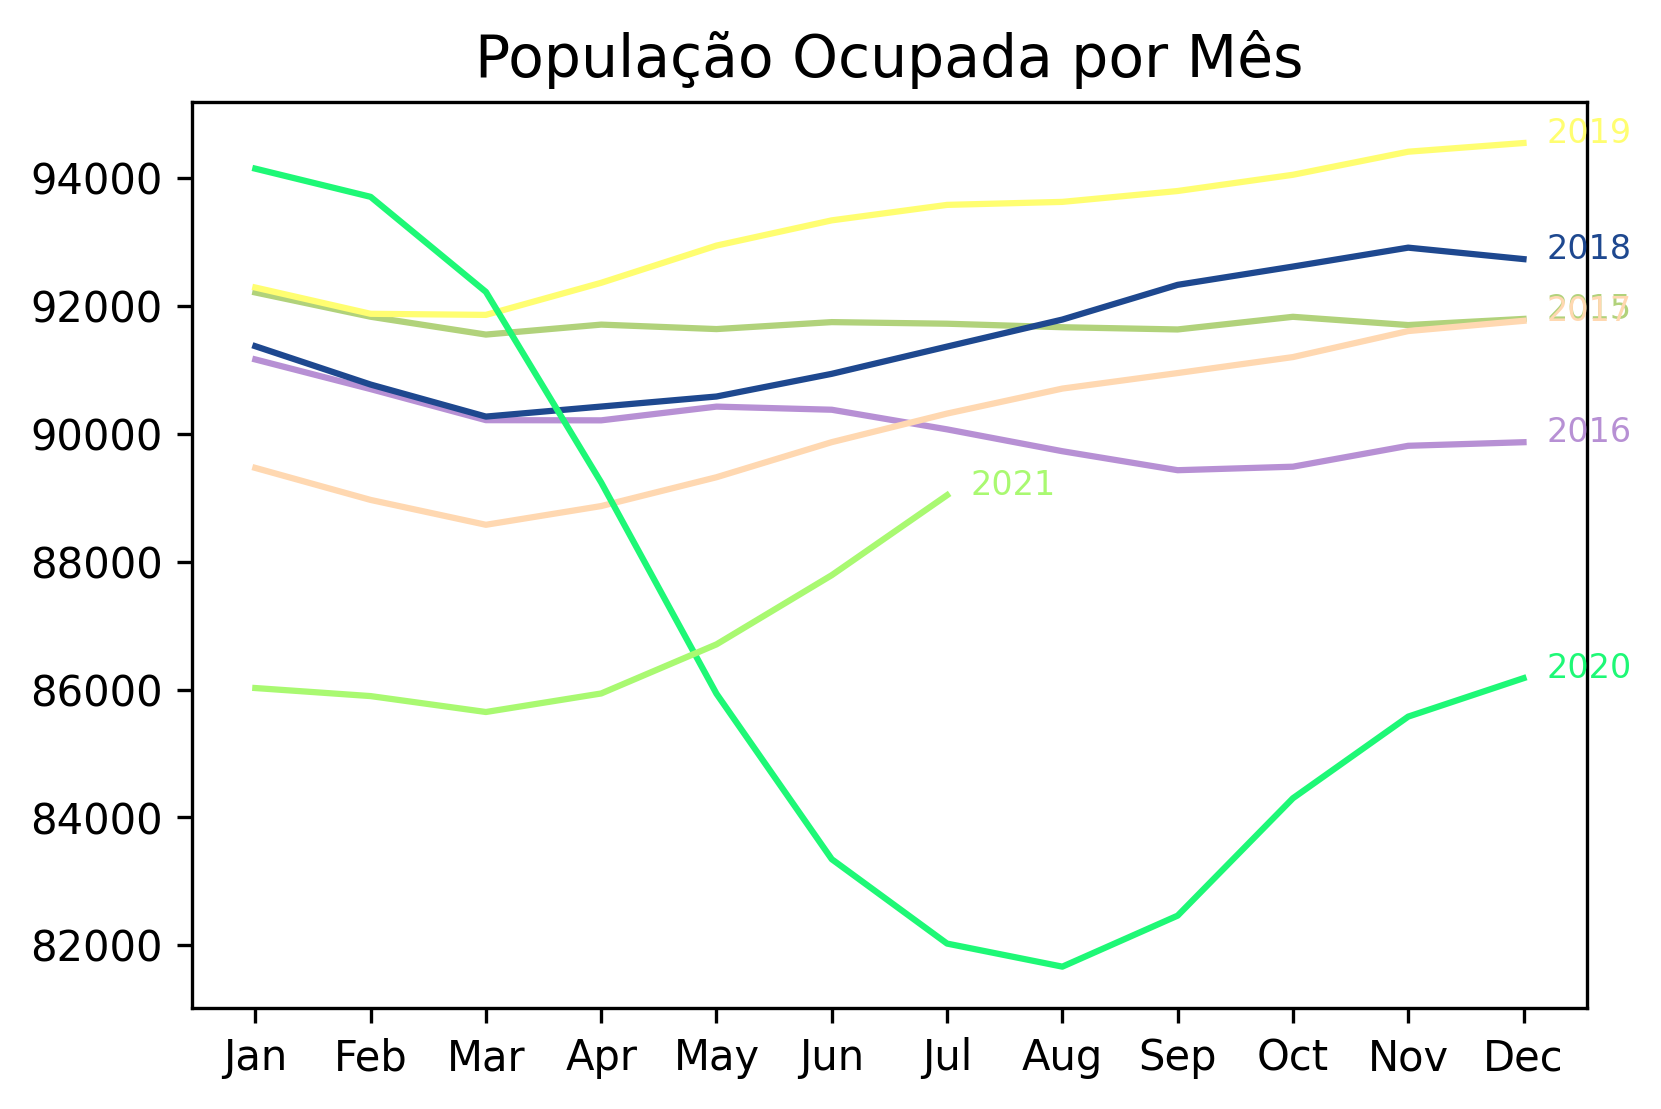

In [ ]:
## Lista de anos
lAnos = df2015['ano'].unique()

# Cores
np.random.seed(1)
lCores = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(lAnos), replace=False)

## Criando o gráfico
plt.figure(figsize=(6,4), dpi= 300)

## Para cada ano,
# enumerate: ver próxima célula
for i, y in enumerate(lAnos):
    plt.plot('mes', 'ocupados', data=df2015.loc[df2015.ano==y, :], color=lCores[i], label=y)
    plt.text(df2015.loc[df2015.ano==y, :].shape[0] -.8, df2015.loc[df2015.ano==y, 'ocupados'][-1:].values[0], y, fontsize=8, color=lCores[i])

plt.title("População Ocupada por Mês", fontsize=14)
# plt.show()

In [ ]:
## Vendo enumerate
dict(enumerate(lAnos))

{0: 2015, 1: 2016, 2: 2017, 3: 2018, 4: 2019, 5: 2020, 6: 2021}

In [ ]:
## Colocando data como index
df = df.set_index('data', drop=False)

# Especificando frequência mensal
df = df.asfreq('MS')

De modo geral, a população empregada cresce ao longo do ano e cai no primeiro trimestre do ano subsequente (fim de contratações temporárias por conta das festas de fim de ano).

Podemos ver isso melhor com um gráfico de boxplots:

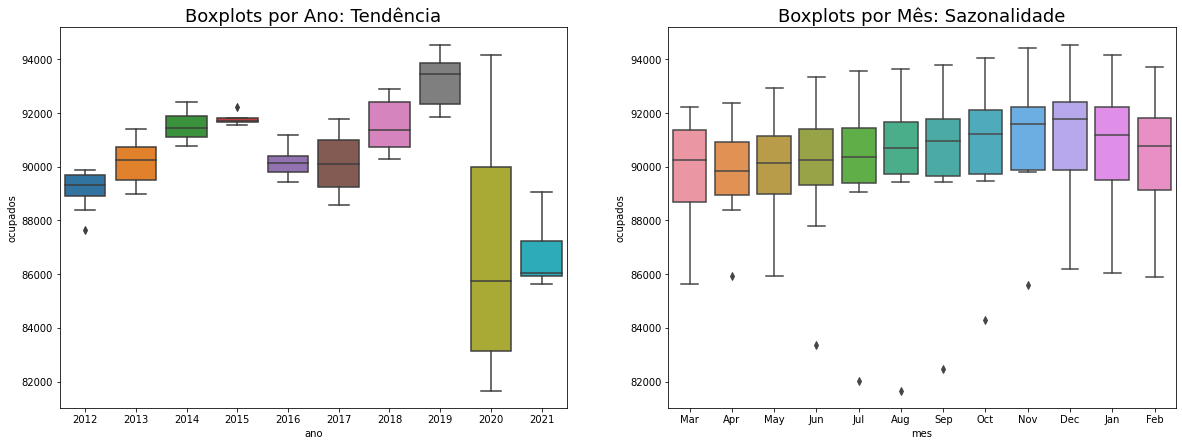

In [ ]:
## Desenhando o gráfico usando o seaborn
# Seaborn: bibilioteca baseada no matplotlib, mas mais potente/"científica"

# Criando um gráfico de uma linha com duas colunas
fig, ax = plt.subplots(1, 2, figsize=(20,7))

# Distribuição de cada ano
sns.boxplot(x='ano', y='ocupados', data=df, ax=ax[0])

# Distribuição de cada mês
sns.boxplot(x='mes', y='ocupados', data=df, ax=ax[1])

# Set Title
ax[0].set_title('Boxplots por Ano: Tendência', fontsize=18); 
ax[1].set_title('Boxplots por Mês: Sazonalidade', fontsize=18)
plt.show()

## Séries Estacionárias e Teste de Estacionariedade

Uma série é dita estacionária quando seus valores não são função do tempo.
Em outras palavras, suas propriedades estátisticas (média, variância, autocorrelação) são constantes ao longo do tempo.

Séries estacionárias são importantes porque facilitam a adoção de modelos preditivos (principalmente lineares).
Vimos que um dos pressupostos da Regressão Linear é que as variáveis independentes não podem ser auto-correlacionadas, o que não ocorre com séries estacionárias.

In [ ]:
## Testando a estacionaridade da série
# Módulos
from statsmodels.tsa.stattools import adfuller, kpss

In [ ]:
## Testando estacionariedade usando o teste Aumentado de Dickey Fuller (ADF)
resultado_adf = adfuller(df['ocupados'], autolag='AIC')
print(f"P-valor do teste: {resultado_adf[1]}")
print("H0: a série NÃO é estacionária e possui raiz unitária.")
# Como p < 0,05, rejeitamos H0: a série é estacionária.

P-valor do teste: 0.0007005818786185844
H0: a série NÃO é estacionária e possui raiz unitária.


In [ ]:
## Testando estacionariedade da tendência usando o teste KPSS
resultado_kpss = kpss(df['ocupados'])
print(f"P-valor do teste: {resultado_kpss[1]}")
print("H0: a série é estacionária e NÃO possui raiz unitária.")

# Warning: pela distribuição da série, o p-valor não pode ser calculado de maneira exata,
# mas tem como valor mínimo 0,1 (não se pode rejeitar H0)
# Mais infos: https://stats.stackexchange.com/questions/286124/kpss-test-in-python-with-statsmodels/286167

P-valor do teste: 0.1
H0: a série é estacionária e NÃO possui raiz unitária.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


## Autocorrelação

Quanto maior a autocorrelação de uma série, mais úteis são os valores anteriores como preditores dos valores futuros.

In [ ]:
## Módulos necessários
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

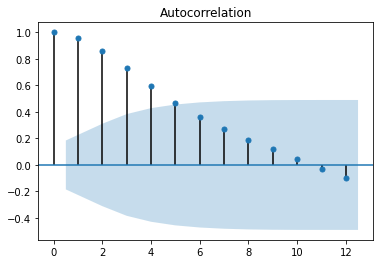

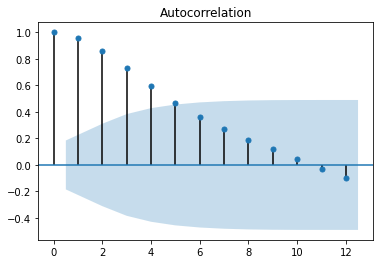

In [ ]:
## Vendo a autocorrelação com valores até 1 anos antes
plot_acf(df.ocupados.tolist(), lags=12)

# Área sombreada: zona de significância (auto correlação até 4 termos é significante).

Uma outra forma de se distinguir ruído branco e série estacionária é pelo plot de autocorrelação: se todos os valores estiverem dentro do intervalo de confiança (que não estão), a série é um ruído branco.

Nossa série, portanto, é estacionária, mas não um ruído branco.

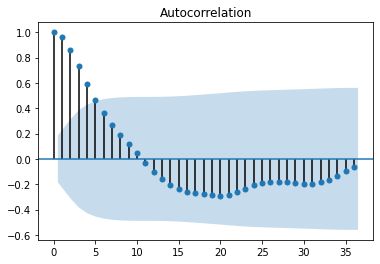

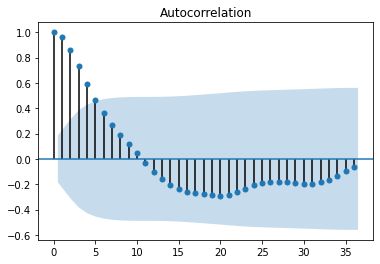

In [ ]:
## Vendo a autocorrelação com valores até 3 anos antes
plot_acf(df.ocupados.tolist(), lags=36)

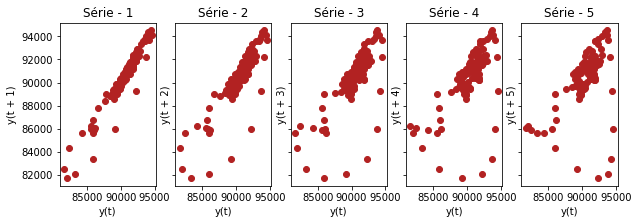

In [ ]:
## Podemos visualizar a autocorrelação de uma outra forma, criando um scatterplot 
# Eixo x: série; Eixo y: série + algum período
from pandas.plotting import lag_plot

## Criando objeto gráfico com 1 linha e 4 colunas e eixos na mesma dimensão
fig, ax = plt.subplots(1, 5, figsize=(10,3), sharex=True, sharey=True)

## Loopando através de cada posição e plotando
for i, ax in enumerate(ax.flatten()[:5]):
    lag_plot(df.ocupados, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Série - ' + str(i+1))

## Vemos que se forma uma reta de 45º graus em todos os plots, o que
## significa que a série possui alta correlação (principalmente de 1º estágio)

## Séries Estacionárias x Ruído Branco

Assim como uma série estacionária, um ruído branco não possui mudanças em suas estatísticas.
Contudo, o ruído branco é completamente aleatório (ou seja, não possui autocorrelação) e possui média 0.

Em termos de equação, um ruído branco é uma série temporal

Y<sub>t</sub> = H Y<sub>t</sub> + e<sub>t</sub>,

onde H é **zero** (não há correlação serial/autocorrelação) e e<sub>t</sub> é um termo de erro que segue uma distribuição aleatória normal com variância constante e média 0.

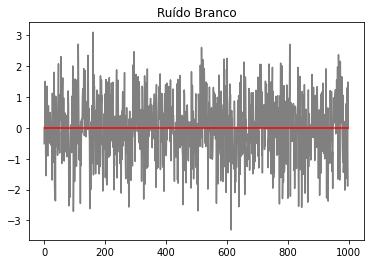

In [ ]:
## Valores normais aleatórios
valores_aleatorios_normais = np.random.randn(1000)

## Plottando
plt.hlines(y=0, xmin=0, xmax=1000, color="red", zorder=5)
pd.Series(valores_aleatorios_normais).plot(title='Ruído Branco', color='gray', zorder=0)

# Passeios Aleatórios

"*O melhor chute para o valor de hoje é o valor de ontem.*"

*Algum sábio do mercado financeiro*




## Sem deslocamento

Em termos de equação, um **passeio aleatório sem deslocamento** é uma série temporal

Y<sub>t</sub> = H Y<sub>t</sub> + e<sub>t</sub>,

onde H é **diferente de zero** (há correlação serial/autocorrelação) e e<sub>t</sub> é um termo de erro que segue uma distribuição aleatória normal.

Diferentemente de um ruído branco ou de uma série estacionária, sua média é diferente de 0 e possui uma variância não constante.

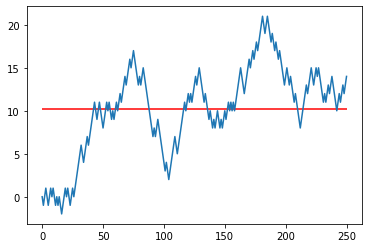

In [ ]:
## Criando os dados
# Valor inicial 0
passeio = [0]

## Criando 250 valores
for i in range(250):
    # Criando o erro aleatório: random fornece um valor aleatório entre 0 e 1
    # Se menor que 0.5, diminuir 1, caso contrário, somar 1
    erro = -1 if np.random.random() < 0.5 else 1
    passeio.append(passeio[-1] + erro)

## Plottando a série e sua média
plt.plot(passeio)
plt.hlines(y=np.mean(passeio), xmin=0, xmax=250, color='red')

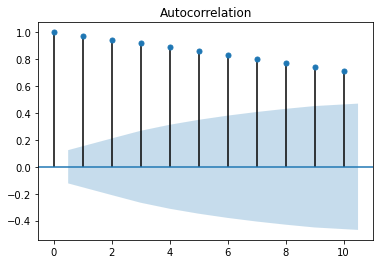

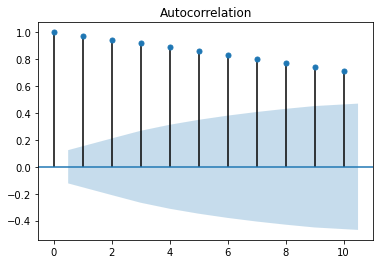

In [ ]:
## Vendo a autocorrelação: ela fica, majoritariamente, fora do intervalo sombreado
# Ou seja, não pode ser ruído branco!
plot_acf(passeio, lags=10)

Média: 0.056


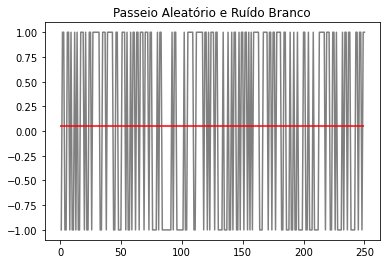

In [ ]:
## Pela forma como são criadas, a diferenciação de um passeio aleatório deve gerar um passeio aleatório:
# Diferenciado
passeio_diferenca = pd.Series(passeio).diff()

# Plottando
## Plottando
plt.hlines(y=np.mean(passeio_diferenca), xmin=0, xmax=250, color="red", zorder=5)
passeio_diferenca.plot(title='Passeio Aleatório e Ruído Branco', color='gray', zorder=0)
print(f"Média: {np.mean(passeio_diferenca)}")

Média: 12.589285714285714


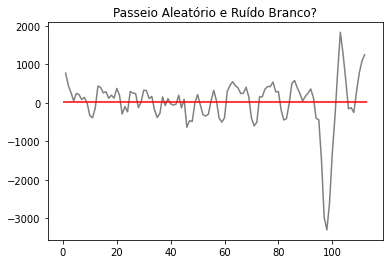

In [ ]:
## Fazendo a mesma coisa com nossa série de ocupados para testar se ela é um passeio aleatório
# Diferenciado
ocupados_diferenca = pd.Series(df.ocupados).diff().reset_index(drop=True)

# Plottando
## Plottando
plt.hlines(y=np.mean(ocupados_diferenca), xmin=0, xmax=ocupados_diferenca.shape[0], color="red", zorder=5)
ocupados_diferenca.plot(title='Passeio Aleatório e Ruído Branco?', color='gray', zorder=0)
print(f"Média: {np.mean(ocupados_diferenca)}")

A média é próxima de 0 (dado que os valores estão na casa de milhões); será que nossa série é um passeio aleatório?

Lembre-se que uma série estacionária possui média variância (e consequentemente, desvio-padrão) constante ao longo do tempo, enquanto isso não ocorre com passeios aleatórios.

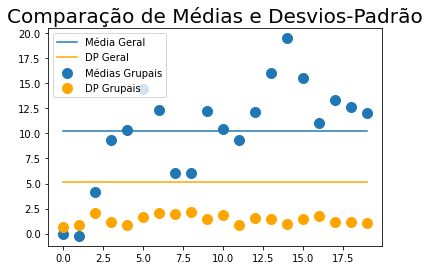

In [ ]:
## Passeio aleatório
# Separando o array em 20 grupos de tamanhos (quase) iguais (array_split)
chunks = np.array_split(passeio, 20)

# Criando lista para armazenar médias e desvios-padrão
medias, desvios_padrao = [], []

# Média e desvio padrão de cada grupo
for chunk in chunks:
    medias.append(np.mean(chunk))
    desvios_padrao.append(np.std(chunk))
    
    
# Plottando
plt.title('Comparação de Médias e Desvios-Padrão', size=20)
plt.plot(np.arange(len(medias)), [np.mean(passeio)] * len(medias), label='Média Geral', lw=1.5)
plt.scatter(x=np.arange(len(medias)), y=medias, label='Médias Grupais', s=100)
plt.plot(np.arange(len(desvios_padrao)), [np.std(passeio)] * len(desvios_padrao), label='DP Geral', lw=1.5, color='orange')
plt.scatter(x=np.arange(len(desvios_padrao)), y=desvios_padrao, label='DP Grupais', color='orange', s=100)
plt.legend()

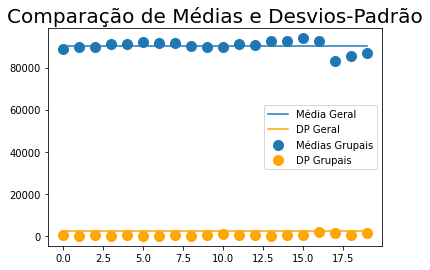

In [ ]:
## Passeio aleatório
# Separando o array em 20 grupos de tamanhos (quase) iguais (array_split)
chunks = np.array_split(df.ocupados.values, 20)

# Criando lista para armazenar médias e desvios-padrão
medias, desvios_padrao = [], []

# Média e desvio padrão de cada grupo
for chunk in chunks:
    medias.append(np.mean(chunk))
    desvios_padrao.append(np.std(chunk))
    
    
# Plottando
plt.title('Comparação de Médias e Desvios-Padrão', size=20)
plt.plot(np.arange(len(medias)), [np.mean(df.ocupados.values)] * len(medias), label='Média Geral', lw=1.5)
plt.scatter(x=np.arange(len(medias)), y=medias, label='Médias Grupais', s=100)
plt.plot(np.arange(len(desvios_padrao)), [np.std(df.ocupados.values)] * len(desvios_padrao), label='DP Geral', lw=1.5, color='orange')
plt.scatter(x=np.arange(len(desvios_padrao)), y=desvios_padrao, label='DP Grupais', color='orange', s=100)
plt.legend()

### Passeio Aleatório com Deslocamento

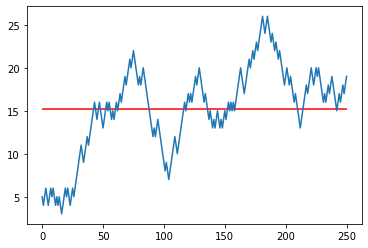

In [ ]:
## Adicionando o deslocamento a cada etapa
passeio_deslocamento = pd.Series(passeio) + 5

## Plottando a série e sua média
plt.plot(passeio_deslocamento)
plt.hlines(y=np.mean(passeio_deslocamento), xmin=0, xmax=250, color='red')

Média: 0.056


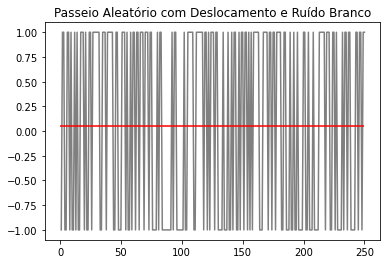

In [ ]:
## Pela forma como são criadas, a diferenciação de um passeio aleatório deve gerar um passeio aleatório:
# Diferenciado
passeio_deslocamento_diferenca = pd.Series(passeio_deslocamento).diff()

# Plottando
## Plottando
plt.hlines(y=np.mean(passeio_deslocamento_diferenca), xmin=0, xmax=250, color="red", zorder=5)
passeio_diferenca.plot(title='Passeio Aleatório com Deslocamento e Ruído Branco', color='gray', zorder=0)
print(f"Média: {np.mean(passeio_deslocamento_diferenca)}")

# Exportações e Importações: Teste de Cointegração e Quebras Estruturais

In [ ]:
sArquivo = "exportacoes_importacoes.xlsx"

## Lendo o DataFrane
dfExpImp = pd.read_excel(f"{sCaminho}{sArquivo}")

# Vendo o tamanho da base
print(f"Linhas: {dfExpImp.shape[0]}; Colunas: {dfExpImp.shape[1]}")

Linhas: 253; Colunas: 7


In [ ]:
## Vendo a base
dfExpImp.head(20)

,data,exportacao_indice_quantum,exportacao_indice_preco,importacao_indice_quantum,importacao_indice_preco,txcambio_realefetiva_expor_INPC,txcambio_realefetiva_impor_INPC
0,2000-03-01,47.806667,73.226667,68.550000,77.243333,140.360077,136.192953
1,2000-04-01,50.713333,73.223333,71.900000,76.050000,138.469159,134.306827
2,2000-05-01,54.100000,73.663333,75.543333,76.183333,138.586178,134.356733
3,2000-06-01,55.586667,73.733333,76.176667,76.423333,139.826678,135.669016
4,2000-07-01,58.330000,74.393333,81.076667,76.593333,139.646937,135.582824
5,2000-08-01,59.596667,75.003333,85.326667,76.560000,137.922733,133.957281
6,2000-09-01,58.686667,75.503333,87.930000,76.513333,136.146996,132.107348
7,2000-10-01,57.610000,75.046667,88.943333,77.133333,136.013910,131.831213
8,2000-11-01,53.903333,74.173333,86.140000,77.700000,138.215528,133.861405
9,2000-12-01,53.766667,74.020000,84.723333,78.066667,141.268079,136.849339


In [ ]:
## Convertendo a coluna de data pra datetime
dfExpImp['data'] = pd.to_datetime(dfExpImp['data'])

[Text(0, 0.5, 'Índice'),
 Text(0.5, 0, 'Mês e Ano'),
 Text(0.5, 1.0, 'Quantum de Comércio Internacional')]

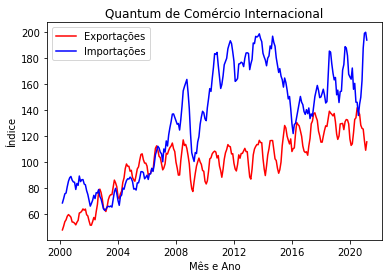

In [ ]:
## Grafando o comportamento das séries
plt.plot(dfExpImp.data, dfExpImp.exportacao_indice_quantum, color="red", label="Exportações")
plt.plot(dfExpImp.data, dfExpImp.importacao_indice_quantum, color="blue", label="Importações")
plt.legend()
plt.gca().set(title="Quantum de Comércio Internacional", xlabel="Mês e Ano", ylabel="Índice")

In [ ]:
## Vendo dados de 2008
dfExpImp.query("data.dt.year == 2008")

,data,exportacao_indice_quantum,exportacao_indice_preco,importacao_indice_quantum,importacao_indice_preco,txcambio_realefetiva_expor_INPC,txcambio_realefetiva_impor_INPC
94,2008-01-01,99.926667,121.286667,131.913333,116.586667,112.081376,111.622559
95,2008-02-01,95.326667,123.503333,129.053333,118.960000,111.324653,110.896073
96,2008-03-01,89.953333,125.800000,129.663333,122.176667,110.984124,110.567357
97,2008-04-01,90.040000,128.120000,124.613333,126.896667,110.447201,109.905106
98,2008-05-01,101.086667,132.360000,132.570000,129.956667,109.595327,108.800116
99,2008-06-01,109.380000,138.533333,142.943333,133.590000,107.270905,106.256802
100,2008-07-01,117.050000,145.903333,154.756667,137.070000,104.779823,103.658131
101,2008-08-01,112.733333,152.476667,158.010000,140.450000,102.951523,101.826536
102,2008-09-01,113.600000,155.016667,160.776667,141.903333,105.292563,104.202650
103,2008-10-01,110.450000,154.236667,163.543333,139.710000,113.339710,112.421258


## Testando estacionariedade e diferenciação de séries temporais

In [ ]:
## Testando estacionariedade usando o teste Aumentado de Dickey Fuller (ADF)
# Exportações
resultado_adf_exp = adfuller(dfExpImp['exportacao_indice_quantum'], autolag='AIC')
print(f"P-valor do teste: {resultado_adf_exp[1]}")
print("H0: a série NÃO é estacionária e possui raiz unitária.")

P-valor do teste: 0.3563299012692863
H0: a série NÃO é estacionária e possui raiz unitária.


In [ ]:
# Importações
resultado_adf_imp = adfuller(dfExpImp['importacao_indice_quantum'], autolag='AIC')
print(f"P-valor do teste: {resultado_adf_imp[1]}")
print("H0: a série NÃO é estacionária e possui raiz unitária.")

P-valor do teste: 0.6973008106100915
H0: a série NÃO é estacionária e possui raiz unitária.


Ambas as séries NÃO são estacionárias: assim, precisamos torná-las estacionárias, o que pode ser feito através de diferenciação.

In [ ]:
## Diferenciado Exportações
dfExpImp['exportacao_diff'] = dfExpImp['exportacao_indice_quantum'].diff()
dfExpImp[['exportacao_indice_quantum', 'exportacao_diff']]

,exportacao_indice_quantum,exportacao_diff
0,47.806667,NaN
1,50.713333,2.906667
2,54.100000,3.386667
3,55.586667,1.486667
4,58.330000,2.743333
...,...,...
248,125.920000,-2.426667
249,125.363333,-0.556667
250,116.383333,-8.980000
251,109.083333,-7.300000


In [ ]:
## Retirando o NaN do início
exportacao_diff = dfExpImp['exportacao_diff'].values[1:]

## Testando estacionariedade
resultado_adf_exp_diff = adfuller(exportacao_diff, autolag='AIC')
print(f"P-valor do teste: {resultado_adf_exp_diff[1]}")
print("H0: a série NÃO é estacionária e possui raiz unitária.")

## A série se torna estacionária!!!

P-valor do teste: 0.00015940511685706075
H0: a série NÃO é estacionária e possui raiz unitária.


In [ ]:
## Fazendo a mesma coisa com importações

dfExpImp['importacao_diff'] = dfExpImp['importacao_indice_quantum'].diff()

## Retirando o NaN do início
importacao_diff = dfExpImp['importacao_diff'].values[1:]

## Testando estacionariedade
resultado_adf_imp_diff = adfuller(importacao_diff, autolag='AIC')
print(f"P-valor do teste: {resultado_adf_imp_diff[1]}")
print("H0: a série NÃO é estacionária e possui raiz unitária.")

## A série se torna estacionária!!!

P-valor do teste: 0.0009469016086370704
H0: a série NÃO é estacionária e possui raiz unitária.


## Testando Cointegração

Statsmodels usa o Teste Aumentado de Engle-Granger, onde H0: não há cointegração.

Para funcionar, ambas as séries precisam ser estacionárias.

In [ ]:
from statsmodels.tsa.stattools import coint

In [ ]:
## Fazendo o teste de cointegração
# trend='ct' estipula que ambas as séries possuem uma tendência linear definida ao longo do tempo
# (no nosso caso, crescente; vide gráfico acima)
cointegracao = coint(exportacao_diff, 
                     importacao_diff,
                     trend='ct')
print(f"P-valor:{cointegracao[1]}")

P-valor:0.0013144927287533706


Séries bastante cointegradas!

In [ ]:
## Mesmo código, mas sem corrigir não-estacionariedade: não podemos 
## mais rejeitar H0: séries não são cointegradas.
cointegracao = coint(dfExpImp.exportacao_indice_quantum.values, 
                        dfExpImp.importacao_indice_quantum.values,
                        trend='ct')
print(f"P-valor:{cointegracao[1]}")

P-valor:0.6705834835364324


## Testes de Quebra Estrutural: Testes de Chow

Limitação: precisamos ter uma hipótese de data na qual ocorre a quebra.

H0: não houve quebra estrutural

In [ ]:
## Para fazer o teste, precisamos de três regressões:
# Uma de todo o período;
# Uma do período pré-quebra;
# E outra do período pé quebra

## Importando o módulo
from statsmodels.formula.api import ols

In [ ]:
## Como o python interpreta data como uma variável categórica, vamos criar uma coluna de contagem que,
## que captará o efeito da passagem do tempo
dfExpImp["tempo"] = dfExpImp.index + 1
dfExpImp

,data,exportacao_indice_quantum,exportacao_indice_preco,importacao_indice_quantum,importacao_indice_preco,txcambio_realefetiva_expor_INPC,txcambio_realefetiva_impor_INPC,exportacao_diff,importacao_diff,tempo
0,2000-03-01,47.806667,73.226667,68.550000,77.243333,140.360077,136.192953,NaN,NaN,1
1,2000-04-01,50.713333,73.223333,71.900000,76.050000,138.469159,134.306827,2.906667,3.350000,2
2,2000-05-01,54.100000,73.663333,75.543333,76.183333,138.586178,134.356733,3.386667,3.643333,3
3,2000-06-01,55.586667,73.733333,76.176667,76.423333,139.826678,135.669016,1.486667,0.633333,4
4,2000-07-01,58.330000,74.393333,81.076667,76.593333,139.646937,135.582824,2.743333,4.900000,5
...,...,...,...,...,...,...,...,...,...,...
248,2020-11-01,125.920000,122.743333,162.586667,103.683333,197.307942,197.166174,-2.426667,12.720000,249
249,2020-12-01,125.363333,123.543333,187.593333,103.940000,194.198149,194.012969,-0.556667,25.006667,250
250,2021-01-01,116.383333,126.640000,199.033333,104.533333,191.617321,191.339727,-8.980000,11.440000,251
251,2021-02-01,109.083333,132.283333,199.833333,105.880000,NaN,NaN,-7.300000,0.800000,252


In [ ]:
## Formula
formula = "importacao_indice_quantum ~ 1 + tempo"

## Modelo com todos os dados
modelo_geral = ols(formula, dfExpImp).fit(use_t=True)

## Pegando a soma dos quadrados dos resíduos do modelo
# Squared Sum of Residuals: SSR
ssr_geral = modelo_geral.ssr
print(ssr_geral)

154053.35557289794


In [ ]:
## Modelo com dados pré-2009
modelo_pre2009 = ols(formula, dfExpImp.query("data.dt.year < 2009")).fit(use_t=True)

## Pegando a soma dos quadrados dos resíduos do modelo
# Squared Sum of Residuals: SSR
ssr_pre2009 = modelo_pre2009.ssr
print(ssr_pre2009)

24201.487011520498


In [ ]:
## Modelo com dados pós-2009
modelo_pos2009 = ols(formula, dfExpImp.query("data.dt.year >= 2009")).fit(use_t=True)

## Pegando a soma dos quadrados dos resíduos do modelo
# Squared Sum of Residuals: SSR
ssr_pos2009 = modelo_pos2009.ssr
print(ssr_pos2009)

76031.93732213415


In [ ]:
## Computando a estatística de Chow, que segue uma distribuição F com
# 2 graus de liiberdade no numerador (número de parametros)
# 249 graus de liberdade no denominador (número de observações - 2*número de parâmetros)
gl_numerador = len(modelo_geral.params)
gl_denominador = dfExpImp.shape[0] - 2*gl_numerador

In [ ]:
numerador_chow = (ssr_geral - (ssr_pre2009 + ssr_pos2009)) / gl_numerador
denominador_chow = (ssr_pre2009 + ssr_pos2009) / gl_denominador

estatistica_chow = numerador_chow/denominador_chow

In [ ]:
## Vendo o p-valor de F(2, 249)
p_valor_chow = stats.f.sf(estatistica_chow, gl_numerador, gl_denominador)
print(p_valor_chow)

## O p-valor é de 0 até 24 casas decimais: assim não se pode rejeitar H0: não houve quebra.

5.7677302729597685e-24
